In [1]:
import matplotlib.pyplot as plt
import numpy as np


from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
np.set_printoptions(linewidth=100) 

plt.rcParams.update({'font.size': 14})

In [2]:
### load the data

# GNSS
GNSS = np.genfromtxt('./data/GNSS_at_SWOT_times_SSH_only.csv', delimiter=",")

# SWOT
SWOT = np.genfromtxt('./data/SWOT_at_buoys_SSH_only.csv', delimiter=",")

# load coordinates
coords = np.genfromtxt('./data/buoy_locations_FSP_UTM.csv', delimiter=",")

# load mean SSH from buoys
mean_GNSS = np.genfromtxt('./data/GNSS_mean_SSH.csv', delimiter=",")

# convert m to cm
GNSS = GNSS*100
SWOT = SWOT*100
mean_GNSS = mean_GNSS*100

In [3]:
### remove the mean ssh from each site

for i in range(np.shape(GNSS)[0]):
    SWOT[i, :] = SWOT[i, :] - mean_GNSS[i]    
    GNSS[i, :] = GNSS[i, :] - mean_GNSS[i]

In [4]:
### discard times without complete data (i.e. we want nine data points for every variogram, consistent between datasets)

# print shape
print("Shape of GNSS before NaN removal: ", np.shape(GNSS))
print("Shape of SWOT before NaN removal: ", np.shape(SWOT))

# print number of nans in each
print("Number of NaNs in GNSS: ", len(GNSS[np.isnan(GNSS)]))
print("Number of NaNs in SWOT: ", len(GNSS[np.isnan(SWOT)]))

GNSS_full = []
SWOT_full = []

for i in range(len(GNSS[0, :])):    
#     print(i)
    gnss_row = GNSS[:, i]
    swot_row = SWOT[:, i]

    if len(gnss_row[np.isnan(gnss_row)]) == 0:
#         print('GNSS ', gnss_row)
        if len(swot_row[np.isnan(swot_row)]) == 0:
#             print('SWOT ', swot_row)
            GNSS_full.append(gnss_row)
            SWOT_full.append(swot_row)
    
            

GNSS_full = np.array(GNSS_full).T
SWOT_full = np.array(SWOT_full).T

# print shape
print("\nShape of GNSS after NaN removal: ", (np.shape(GNSS_full)))
print("Shape of SWOT after NaN removal: ", (np.shape(GNSS_full)))


# print number of nans in each
print("Check there are now zero nans: ", len(GNSS_full[np.isnan(GNSS_full)]))
print("Check there are now zero nans: ", len(SWOT_full[np.isnan(SWOT_full)]))

Shape of GNSS before NaN removal:  (9, 96)
Shape of SWOT before NaN removal:  (9, 96)
Number of NaNs in GNSS:  102
Number of NaNs in SWOT:  39

Shape of GNSS after NaN removal:  (9, 50)
Shape of SWOT after NaN removal:  (9, 50)
Check there are now zero nans:  0
Check there are now zero nans:  0


In [5]:
# calculate pairwise diffs
GNSS_diffs_sq = np.ones((36, 50))*np.nan
SWOT_diffs_sq = np.ones((36, 50))*np.nan
distances = np.ones((36))*np.nan

# Generate unique pairs of indices
pairs = [(i, j) for i in range(9) for j in range(i + 1, 9)]

# Calculate pairwise differences for the unique pairs
for idx, (i, j) in enumerate(pairs):
    GNSS_diffs_sq[idx, :] = ((GNSS_full[i, :] - GNSS_full[j, :]))**2
    SWOT_diffs_sq[idx, :] = ((SWOT_full[i, :] - SWOT_full[j, :]))**2
    distances[idx] = np.sqrt((coords[i, 0] - coords[j, 0])**2 + (coords[i, 1] - coords[j, 1])**2)

# convert distances to km
distances = distances/1000

# sort data by distance
sort_idx = np.argsort(distances)
distances = distances[sort_idx]
GNSS_diffs_sq = GNSS_diffs_sq[sort_idx]
SWOT_diffs_sq = SWOT_diffs_sq[sort_idx]

In [7]:
### calculate semivariance (half the pairwise squared difference by lag)

lag_list = np.array((10,20,30,40,50,60,70,80))

GNSS_semivar = np.ones((8, 37))*np.nan
SWOT_semivar = np.ones((8, 37))*np.nan

# define the lags bins manually
for i in range(37):
    tmp_GNSS = GNSS_diffs_sq[:,i]
    tmp_SWOT = SWOT_diffs_sq[:,i]
    
    GNSS_semivar[:,i] = np.array(((0.5 * np.nanmean(tmp_GNSS[0:3])), 
                (0.5 * np.nanmean(tmp_GNSS[3:11])), 
                (0.5 * np.nanmean(tmp_GNSS[11:17])),
                (0.5 * np.nanmean(tmp_GNSS[17:22])),
                (0.5 * np.nanmean(tmp_GNSS[22:30])), 
                (0.5 * np.nanmean(tmp_GNSS[30:33])), 
                (0.5 * np.nanmean(tmp_GNSS[33])), 
                (0.5 * np.nanmean(tmp_GNSS[34:36]))))
    
    SWOT_semivar[:,i] = np.array(((0.5 * np.nanmean(tmp_SWOT[0:3])), 
                (0.5 * np.nanmean(tmp_SWOT[3:11])), 
                (0.5 * np.nanmean(tmp_SWOT[11:17])),
                (0.5 * np.nanmean(tmp_SWOT[17:22])),
                (0.5 * np.nanmean(tmp_SWOT[22:30])), 
                (0.5 * np.nanmean(tmp_SWOT[30:33])), 
                (0.5 * np.nanmean(tmp_SWOT[33])), 
                (0.5 * np.nanmean(tmp_SWOT[34:36]))))
    
    
GNSS_semivar_mean = np.mean(GNSS_semivar, axis=1)
SWOT_semivar_mean = np.mean(SWOT_semivar, axis=1)

In [8]:
### calculate the standard error

SWOT_std = np.nanstd(SWOT_semivar, axis=1)
SWOT_SE = SWOT_std/np.sqrt(37)
print(SWOT_SE)

GNSS_std = np.nanstd(GNSS_semivar, axis=1)
GNSS_SE = GNSS_std/np.sqrt(37)
print(GNSS_SE)

[ 0.33929978  0.54634156  1.47333673  3.403915    5.6449027  11.79372474 19.2791494  22.06730867]
[ 0.35373571  0.54850544  1.34525878  3.02485792  5.41239373 11.60564405 18.89784785 22.61960061]


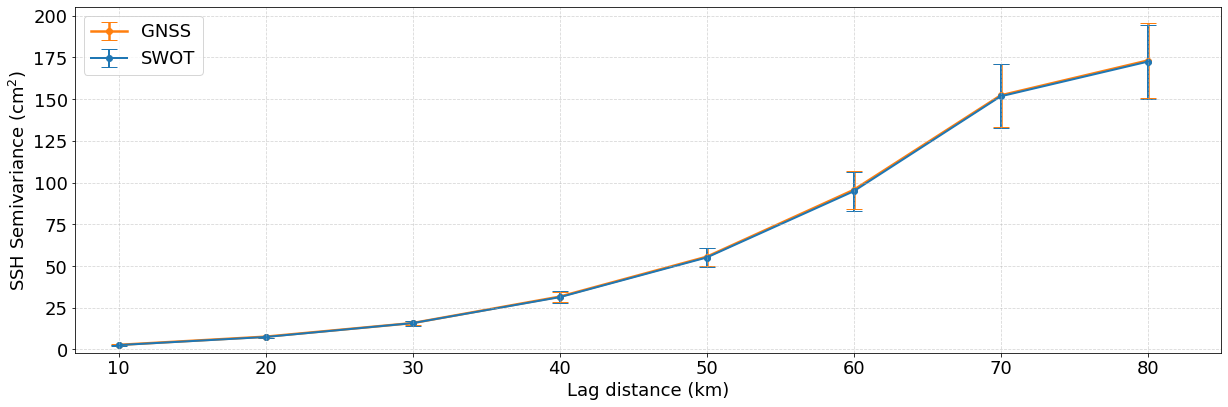

In [9]:
### plot the results

fig_width = 17.4
plt.rcParams.update({'font.size': 18})

fig, ax = plt.subplots(1, 1, figsize=(fig_width, 6))
ax.errorbar(lag_list, GNSS_semivar_mean, yerr=GNSS_SE, capsize=8, c='C1', marker='o', label='GNSS', zorder=1, lw=2.5)
ax.errorbar(lag_list, SWOT_semivar_mean, yerr=SWOT_SE, capsize=8, c='C0', marker='o', label='SWOT', zorder=1, lw=2)
ax.set_xlabel('Lag distance (km)')
ax.set_ylabel('SSH Semivariance (cm$^2$)')
ax.set_ylim(-2,None)
ax.set_xlim(7, 85)
ax.grid(linestyle='--', alpha=0.5)
ax.legend()
plt.tight_layout()
plt.show()


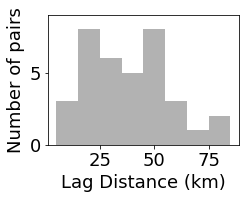

In [10]:
### create a histogram of number of samples per lag

lag_count = np.array((len(tmp_SWOT[0:3]),
                      len(tmp_SWOT[3:11]),
                      len(tmp_SWOT[11:17]),
                      len(tmp_SWOT[17:22]),
                      len(tmp_SWOT[22:30]),
                      len(tmp_SWOT[30:33]),
                      1, #len(tmp_SWOT[33]),
                      len(tmp_SWOT[34:36])))

fig, ax = plt.subplots(1, figsize=(4,3))
plt.bar(lag_list, lag_count, width=10, color='k', alpha=0.3)
ax.set_ylabel('Number of pairs')
ax.set_xlabel('Lag Distance (km)')
ax.set_ylim(0,9)
plt.tight_layout()
plt.show()
